In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import cv2
import torch
import torch.nn as nn
import os
import kornia
import scipy
from scipy import interpolate
import math
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Prevents an unusual error where displaying images will crash the kernel?
#rcParams['figure.figsize'] = 11,8
plt.gray() #Ensures greyscale images are displayed gray without having to use cmap parameter

<Figure size 432x288 with 0 Axes>

## Functions

In [2]:
#Displays Tensors as image
def imshowTorch(input):
    image = kornia.tensor_to_image(input) #Converts to HWC format
    plt.imshow(image) #As matplotlib requires arrays 

In [3]:
#Converts numpy arrays to Kornia compatable tensors
def toKornia(img):
    print(img.shape)
    img = kornia.image_to_tensor(img) #Kornia in shape BCHW
    print(img.shape)
    # #Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    return img

In [4]:
#Converts images to grayscale
# Implented during in class labs
def img2grayscale(img):
    # img = img.astype(np.float32)/255
    # img = (img[:,:,0]+ img[:,:,1]+ img[:,:,2]) / 3
    img_gr = img.copy()
    img_gr = cv2.cvtColor(img_gr, cv2.COLOR_BGR2GRAY)
    return img_gr

In [5]:
##This is provided by the A4 document!!

import numpy as np

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


# flowToColor(np.zeros((224,224,2)))


## Part 1

### Load in Images

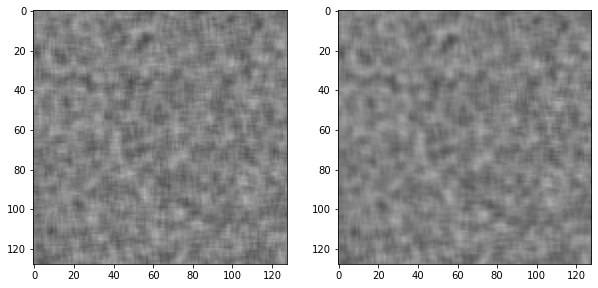

In [6]:
#Start with reading in images
synth0 = cv2.imread('Sequences/synth/synth_0.png')
#plt.imshow(synth1)
synth1 = cv2.imread('Sequences/synth/synth_1.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(synth0)
ax[1].imshow(synth1)

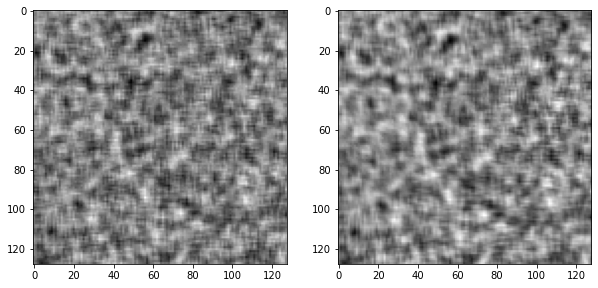

In [7]:
synth0_gr = img2grayscale(synth0)
synth1_gr = img2grayscale(synth1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(synth0_gr)
ax[1].imshow(synth1_gr)

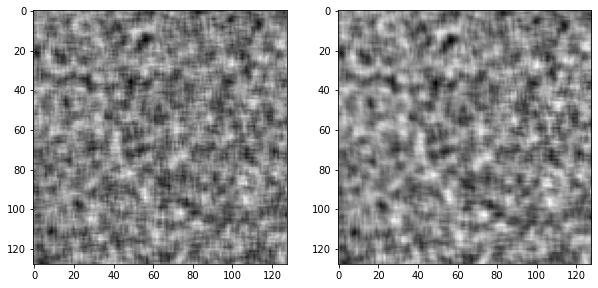

In [8]:
synth0_gr = synth0_gr.astype(np.float32)/255 
synth1_gr = synth1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(synth0_gr)
ax[1].imshow(synth1_gr)

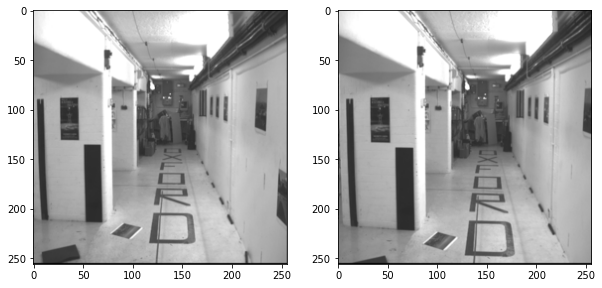

In [9]:
corridor0 = cv2.imread('Sequences/corridor/bt_0.png')
corridor1 = cv2.imread('Sequences/corridor/bt_1.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(corridor0)
ax[1].imshow(corridor1)

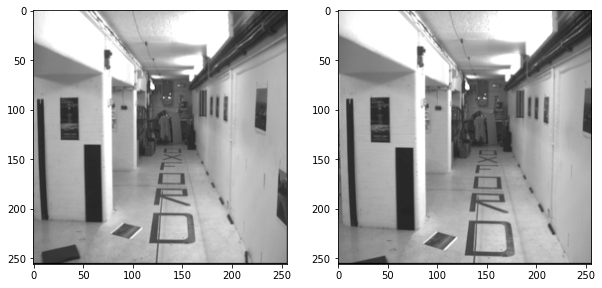

In [10]:
corridor0_gr = img2grayscale(corridor0)
corridor1_gr = img2grayscale(corridor1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(corridor0_gr)
ax[1].imshow(corridor1_gr)

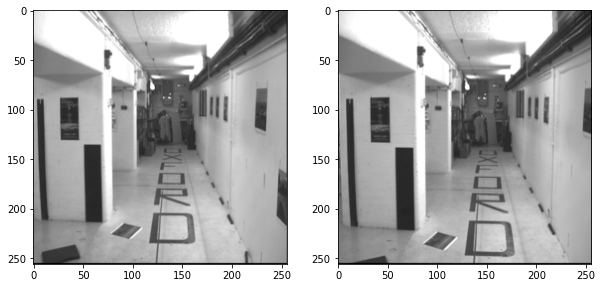

In [11]:
corridor0_gr = corridor0_gr.astype(np.float32)/255 
corridor1_gr = corridor1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(corridor0_gr)
ax[1].imshow(corridor1_gr)

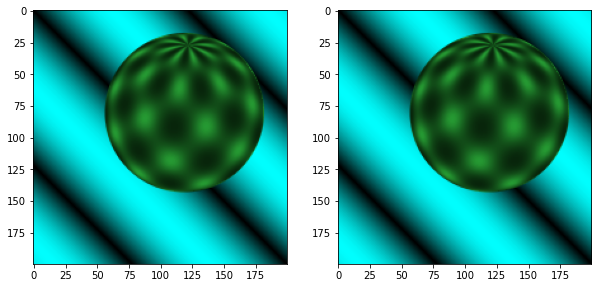

In [12]:
sphere0 = cv2.imread('Sequences/sphere/sphere_0.png')
sphere1 = cv2.imread('Sequences/sphere/sphere_1.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere0)
ax[1].imshow(sphere1)

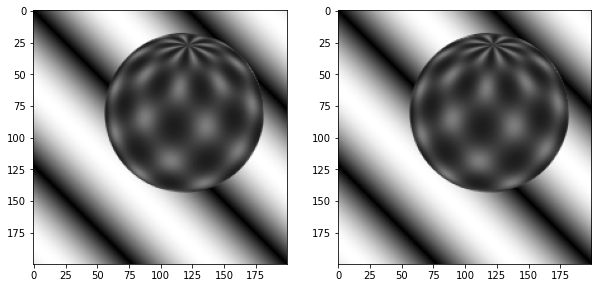

In [13]:
sphere0_gr = img2grayscale(sphere0)
sphere1_gr = img2grayscale(sphere1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere0_gr)
ax[1].imshow(sphere1_gr)

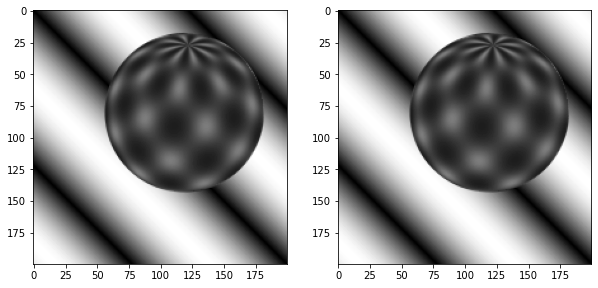

In [14]:
sphere0_gr = sphere0_gr.astype(np.float32)/255 
sphere1_gr = sphere1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere0_gr)
ax[1].imshow(sphere1_gr)

### Now compute flow

In [15]:
from scipy import signal

def myFlow(img0, img1, windowLength, tau):
    #To compute temporal derivative, apply gaussian filtering with a small sigma value (e.g. 3x3 filter with sigma = 1)
    img0_b = cv2.GaussianBlur(img0, (3,3), sigmaX=1)
    img1_b = cv2.GaussianBlur(img1, (3,3), sigmaX=1)

    #Then subtract the first image from the second image
    It = img1_b - img0_b

    #Create the fivetap filter
    #To compute spatial derivatives, use the five tap derivative filter
    fiveTap = [-1, 8, 0, -8, 1]
    fiveTap = np.asarray(fiveTap) * (1/12)

    #Fivetap filter for Ix
    fiveTap3 = [[-1, 8, 0, -8, 1]]
    fiveTap3 = np.asarray(fiveTap3) * (1/12)

    #Fivetap filter for Iy
    fiveTap2 = np.vstack(fiveTap)

    #Compute Ix and Iy
    Ix = signal.convolve2d(img0, fiveTap3)
    #print(Ix)
    Iy = signal.convolve2d(img0, fiveTap2)
    #print(Iy)

    u = np.zeros_like(img0)
    v = np.zeros_like(img0)
    mapping = np.zeros_like(img0)
    window = math.floor(windowLength/2)
    (h,w) = img0.shape
    #tau = 0.001
    #count = 0

    for i in range(window, h - window):
        for j in range(window, w - window): #With this, we cut a window x window shaped....window (lots of windows used in this window sentence)
            #Construct matricies A and b
            A = np.transpose(np.concatenate(([Ix[i-window:i+window+1, j-window:j+window+1].flatten()], [Iy[i-window:i+window+1, j-window:j+window+1].flatten()]), axis=0)) #Containing our Ix and Iy components
            b = np.vstack((It[i-window:i+window+1, j-window:j+window+1].flatten())) #Containing our It components
            #Using minimum least squares, solve for u and v:
            A_T = np.transpose(A)
            A1 = np.matmul(A_T, A)
            eigen = np.linalg.eigvals(A1)
            u[i,j] = 0 #By default, where flow is not computable, set it to zero
            v[i,j] = 0
            mapping[i,j] = 0
            if np.min(abs(eigen)) >= tau: #When greater than some threshold, compute the flow
                A2 = np.linalg.pinv(A)
                A3 = np.matmul(A2, b)
                #print(A3[0])
                u[i,j] = A3[0]
                v[i,j] = A3[1]
                mapping[i,j] = 1

    return u, v, mapping #Returning 3 components, horizontal and vertical components of estimate optical flow and binary mapping

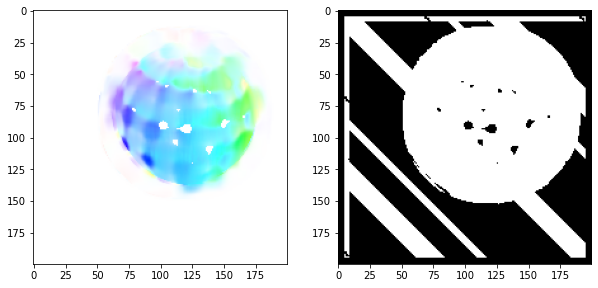

In [16]:
#Display sphere flow
u_sphere, v_sphere, map_sphere = myFlow(sphere0_gr, sphere1_gr, 11, 0.001)
sphere_flow = flowToColor(np.dstack([u_sphere, v_sphere]))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere_flow)
ax[1].imshow(map_sphere)

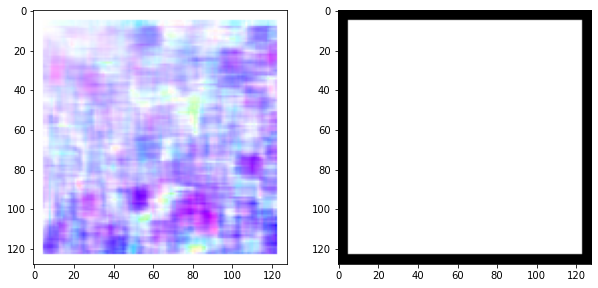

In [17]:
#Display synth flow
u_synth, v_synth, map_synth = myFlow(synth0_gr, synth1_gr, 11, 0.001)
synth_flow = flowToColor(np.dstack([u_synth, v_synth]))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(synth_flow)
ax[1].imshow(map_synth)

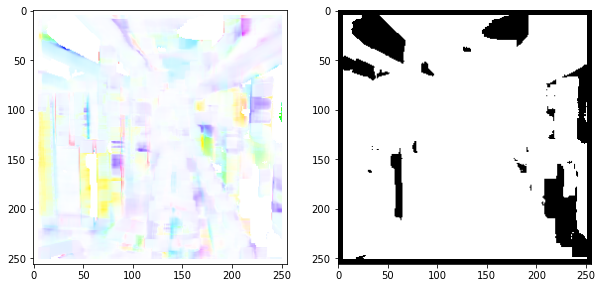

In [18]:
#Display corridor flow
u_corridor, v_corridor, map_corridor = myFlow(corridor0_gr, corridor1_gr, 11, 0.001)
corridor_flow = flowToColor(np.dstack([u_corridor, v_corridor]))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(corridor_flow)
ax[1].imshow(map_corridor)

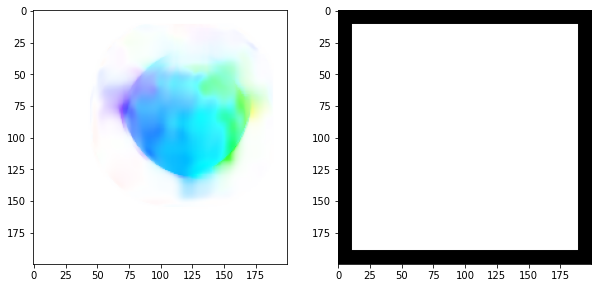

In [20]:
#Display sphere flow
u_sphere, v_sphere, map_sphere = myFlow(sphere0_gr, sphere1_gr, 22, 0.001)
sphere_flow = flowToColor(np.dstack([u_sphere, v_sphere]))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere_flow)
ax[1].imshow(map_sphere)

#We can see that with a larger window, flow is much more generalizablly easy to compute, represented by the white in the binary map.

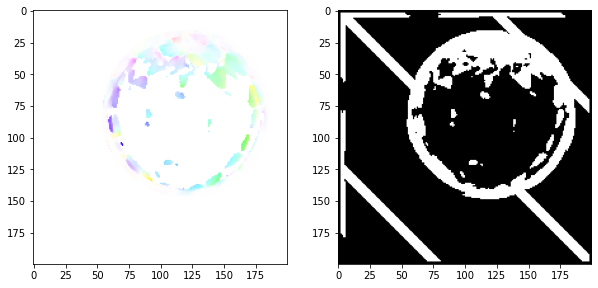

In [21]:
#Display sphere flow
u_sphere, v_sphere, map_sphere = myFlow(sphere0_gr, sphere1_gr, 5, 0.001)
sphere_flow = flowToColor(np.dstack([u_sphere, v_sphere]))
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(sphere_flow)
ax[1].imshow(map_sphere)


#We can see that with a smaller window, there are more regions in which the flow estimate is not computable, represented by the black in the binary map.

## Part 2

In [22]:
def myWarp(u, v, img1):
    flow = np.dstack([u, v])
    (h,w) = flow.shape[:2]

    # x_warp = np.linspace(1, h+1, h)
    # y_warp = np.linspace(1, w+1, w)

    x_warp = np.arange(1, h+1)
    y_warp = np.arange(1, w+1)

    #From https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html
    # Create interpolation functions
    print(flow.shape)
    print(x_warp.shape)
    print(y_warp.shape)
    print(img1.shape)
    f_cubic = scipy.interpolate.interp2d(x_warp, y_warp, img1, kind='cubic')
    f_linear = scipy.interpolate.interp2d(x_warp, y_warp, img1, kind='linear')
    pass

    cubic_result = img1-f_cubic(x_warp, y_warp)
    linear_result = img1-f_linear(x_warp, y_warp) 

    return cubic_result, linear_result #Visualize the difference between warped img2 and img1
    
    

In [23]:
#Example from https://matplotlib.org/stable/users/explain/interactive_guide.html#explicitly-spinning-the-event-loop
# import time
# import matplotlib.pyplot as plt
# import numpy as np
# plt.ion()

# fig, ax = plt.subplots()
# th = np.linspace(0, 2*np.pi, 512)
# ax.set_ylim(-1.5, 1.5)

# ln, = ax.plot(th, np.sin(th))

# def slow_loop(N, ln):
#     for j in range(N):
#         time.sleep(.1)  # to simulate some work
#         ln.figure.canvas.flush_events()

# slow_loop(100, ln)

In [24]:
import time

(200, 200, 2)
(200,)
(200,)
(200, 200)


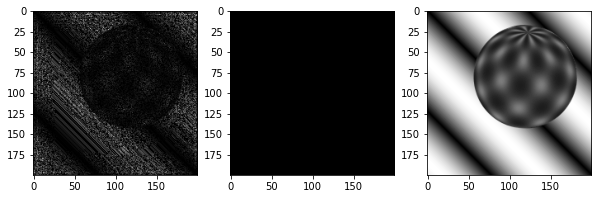

In [25]:
sphere_cubic, sphere_linear = myWarp(u_sphere, v_sphere, sphere1_gr)

fig, ax = plt.subplots(1,3, figsize=(10,10))

ax[0].imshow(np.abs(sphere_cubic)) #Visualize the difference
ax[1].imshow(np.abs(sphere_linear))

#From https://matplotlib.org/stable/users/explain/interactive_guide.html#explicitly-spinning-the-event-loop
for j in range(10):
    time.sleep(.1)
    ln = ax[2].imshow(sphere0_gr) #Display img1 consecutively
    ln.figure.canvas.flush_events()
    ln = ax[2].imshow(sphere_linear + sphere1_gr) #Add back the image to obtain warped img2
    ln.figure.canvas.flush_events()
    plt.draw()

(128, 128, 2)
(128,)
(128,)
(128, 128)


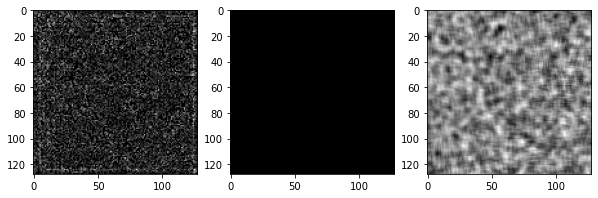

In [26]:
synth_cubic, synth_linear = myWarp(u_synth, v_synth, synth1_gr)

fig, ax = plt.subplots(1,3, figsize=(10,10))

ax[0].imshow(np.abs(synth_cubic)) #Visualize the difference
ax[1].imshow(np.abs(synth_linear))

for j in range(10):
    time.sleep(.1)
    ln = ax[2].imshow(synth0_gr) #Display img1 consecutively
    ln.figure.canvas.flush_events()
    ln = ax[2].imshow(synth_linear + synth1_gr) #Add back the image to obtain warped img2
    ln.figure.canvas.flush_events()
    plt.draw()

(256, 256, 2)
(256,)
(256,)
(256, 256)


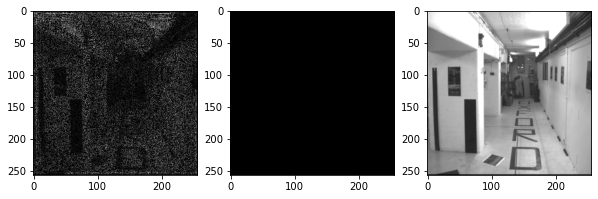

In [27]:
corridor_cubic, corridor_linear = myWarp(u_corridor, v_corridor, corridor1_gr)

fig, ax = plt.subplots(1,3, figsize=(10,10))

ax[0].imshow(np.abs(corridor_cubic)) #Visualize the difference
ax[1].imshow(np.abs(corridor_linear))

for j in range(10):
    time.sleep(.1)
    ln = ax[2].imshow(corridor0_gr) #Display img1 consecutively
    ln.figure.canvas.flush_events()
    ln = ax[2].imshow(corridor_linear + corridor1_gr) #Add back the image to obtain warped img2
    ln.figure.canvas.flush_events()
    plt.draw()

## Part 3

In [28]:
import glob
hotel = [cv2.imread(file) for file in glob.glob("Hotel Sequence/*.png")]

In [29]:
hotel_gray = []
for h in hotel:
    hotel_gray.append(img2grayscale(h))

In [30]:
hotel_gray = np.asarray(hotel_gray)
hotel_gray = hotel_gray.astype(np.float32)/255 

hotel = np.asarray(hotel)
hotel = hotel.astype(np.float32)/255 

#sphere1_gr = sphere1_gr.astype(np.float32)/255 

In [31]:
#Detect set of keypoints in initial (first) frame using harris corner detector
# Using https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gaaf8a051fb13cab1eba5e2149f75e902f
keypoints =  cv2.goodFeaturesToTrack(hotel_gray[0], maxCorners=200, qualityLevel=0.1, minDistance=5, blockSize=7, useHarrisDetector=True)
keypoints.shape

(104, 1, 2)

In [32]:
corners = np.squeeze(np.zeros_like(keypoints))
corners.shape

(104, 2)

In [33]:
for index, corner in enumerate(corners):
    corners[index] = keypoints[index][0]

In [34]:
markers = np.intp(np.round(corners))

In [35]:
#From https://lindevs.com/draw-marker-on-image-using-opencv
# UNCOMMENT THIS TO SEE ALL MARKERS
# for marker in markers:
#     xCorr, yCorr = marker.reshape(-1)
#     color = (0, 255, 0)
#     markerType = cv2.MARKER_CROSS
#     markerSize = 15
#     thickness = 2
#     cv2.drawMarker(hotel[0], (xCorr, yCorr), color, markerType, markerSize, thickness)
#     cv2.drawMarker(hotel_gray[0], (xCorr, yCorr), color, markerType, markerSize, thickness)

# plt.figure(figsize=(10,10))
# plt.imshow(hotel[0])

In [36]:
#Now pick 20 random points
points = []
points = [markers[random.randint(0, markers.shape[0]-1)] for k in range(20)]

In [37]:
markers2 = np.intp(np.round(points))  #20 Random points

In [38]:
#From https://lindevs.com/draw-marker-on-image-using-opencv
# Draw the 20 random markers
for marker in markers2:
    xCorr, yCorr = marker.reshape(-1)
    color = (0, 255, 0)
    markerType = cv2.MARKER_CROSS
    markerSize = 15
    thickness = 2
    cv2.drawMarker(hotel[0], (xCorr, yCorr), color, markerType, markerSize, thickness)
    cv2.drawMarker(hotel_gray[0], (xCorr, yCorr), color, markerType, markerSize, thickness)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


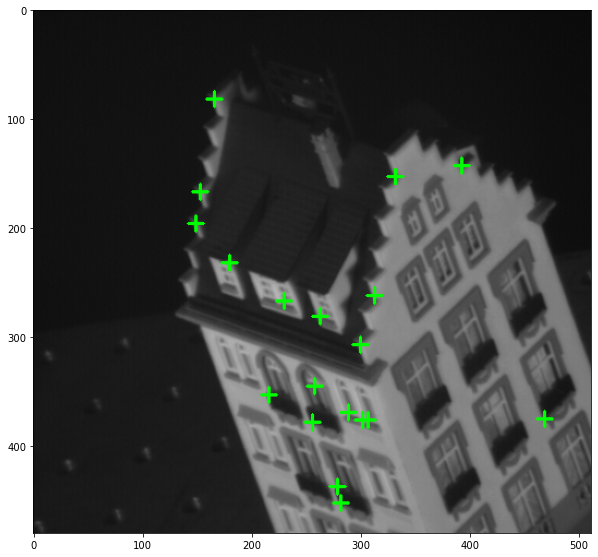

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(hotel[0])

In [40]:
#Using a wWindow size of 15x15
window = (15,15) #
markers_tracked = []

#Track the 20 keypoints from one frame to their next consecutive frame
#Take x_i^t+1 = x_i&^t + u and y_i^t+1 = y_i^t + v
for i in range(len(hotel)-1):
    
    pass
    curImg = hotel_gray[i]
    curImg = curImg.astype(np.float32)
    nextImg = hotel_gray[i+1]
    nextImg = nextImg.astype(np.float32)

    curImg_b = cv2.GaussianBlur(curImg, (3,3), sigmaX=1)
    nextImg_b = cv2.GaussianBlur(nextImg, (3,3), sigmaX=1)


    markers3 = markers2.copy()
    markers3 = markers3.astype(np.float32)

    #Using https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    (Iy, Ix) = np.gradient(curImg_b)

    for j in range(len(markers2)):
        pass #Construct the windows from the Ix, Iy gradient
        Ix_window = cv2.getRectSubPix(Ix, window, (int(markers2[j,0]), int(markers2[j,1])))
        Iy_window = cv2.getRectSubPix(Iy, window, (int(markers2[j,0]), int(markers2[j,1])))
        
        #Construct ATranspose_A matrix
        a11 = np.sum(np.square(Ix_window))
        a21 = np.sum(np.multiply(Ix_window, Iy_window))
        a12 = a21.copy()
        a22 = np.sum(np.square(Iy_window))
        AT_A = [[a11, a21], [a12, a22]]
        AT_A = np.asarray(AT_A)
        
        for k in range(25):
            #Construct It window by taking the difference of the frames
            It_window = cv2.getRectSubPix(nextImg, window, (int(markers3[j,0]), int(markers3[j,1]))) - cv2.getRectSubPix(curImg_b, window, (int(markers2[j,0]), int(markers2[j,1])))
            #Construct ATranpose_b matrix
            b11 = np.sum(np.multiply(Ix_window, It_window))
            b21 = np.sum(np.multiply(Iy_window, It_window))
            AT_b = [[b11], [b21]] 
            AT_b = np.asarray(AT_b) * (-1)
            #Solve for unknowns (u,v)
            pinv = np.linalg.pinv(AT_A)
            sol = np.matmul(pinv, AT_b)
            u = sol[0]
            v = sol[1]
            
            #Discard any keypoints if their location moves out of the frame or is near image borders
    #         if markers3[j,0] + u >= len(curImg) or markers3[j,0] + u < 0 or markers3[j,1] + v >= len(curImg[0]) or markers3[j,1] + v < 0:
    #             #print('a')
    #             continue    
    #         else:
    #             markers3[j] = [markers3[j,0] + u, markers3[j,1] + v] #Move the markers
    #             #print('b')

    #Store the changes in the markers
    # markers2 = markers3
             
    # for mark in markers3:
    #   markers_tracked.append(mark)


#Take markers_tracked and interpolate and display 2D path of the keypoints 

        
        


In [41]:
# Basically, now draw the tracked markers

# for marker in markers_tracked:
#     xCorr, yCorr = marker.reshape(-1)
#     xCorr = int(xCorr)
#     yCorr = int(yCorr)
#     color = (0, 255, 0)
#     markerType = cv2.MARKER_CROSS
#     markerSize = 15
#     thickness = 2
#     cv2.drawMarker(hotel[0], (xCorr, yCorr), color, markerType, markerSize, thickness)
#     cv2.drawMarker(hotel_gray[0], (xCorr, yCorr), color, markerType, markerSize, thickness)

In [42]:
#Display a seperate image of the first frame and overlay the plot of keypoints which have moved out of frame at some point in sequence

# plt.figure(figsize=(10,10))
# plt.imshow(hotel[0])